In [15]:
import pandas as pd
file_path = r"C:\Users\D.Samhitha Franklin\Downloads\archive (7)\dynamic_pricing.csv"
df = pd.read_csv(file_path)


df.head()

,Number_of_Riders,Number_of_Drivers,Location_Category,Customer_Loyalty_Status,Number_of_Past_Rides,Average_Ratings,Time_of_Booking,Vehicle_Type,Expected_Ride_Duration,Historical_Cost_of_Ride
0,90,45,Urban,Silver,13,4.47,Night,Premium,90,284.257273
1,58,39,Suburban,Silver,72,4.06,Evening,Economy,43,173.874753
2,42,31,Rural,Silver,0,3.99,Afternoon,Premium,76,329.795469
3,89,28,Rural,Regular,67,4.31,Afternoon,Premium,134,470.201232
4,78,22,Rural,Regular,74,3.77,Afternoon,Economy,149,579.681422


In [16]:
df.info()
df.describe()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Number_of_Riders         1000 non-null   int64  
 1   Number_of_Drivers        1000 non-null   int64  
 2   Location_Category        1000 non-null   object 
 3   Customer_Loyalty_Status  1000 non-null   object 
 4   Number_of_Past_Rides     1000 non-null   int64  
 5   Average_Ratings          1000 non-null   float64
 6   Time_of_Booking          1000 non-null   object 
 7   Vehicle_Type             1000 non-null   object 
 8   Expected_Ride_Duration   1000 non-null   int64  
 9   Historical_Cost_of_Ride  1000 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 78.3+ KB


Number_of_Riders           0
Number_of_Drivers          0
Location_Category          0
Customer_Loyalty_Status    0
Number_of_Past_Rides       0
Average_Ratings            0
Time_of_Booking            0
Vehicle_Type               0
Expected_Ride_Duration     0
Historical_Cost_of_Ride    0
dtype: int64

In [17]:

# Imports
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# %%
# Configuration
DATA_PATH = Path(r"C:\Users\D.Samhitha Franklin\Downloads\archive (7)\dynamic_pricing.csv")

# %%
# 1) Load data
def load_data(path: Path) -> pd.DataFrame:
    try:
        df = pd.read_csv(path, low_memory=False)
        print(f"Dataset loaded: {df.shape[0]} rows, {df.shape[1]} cols")
        return df
    except Exception as e:
        raise RuntimeError(f"Could not load CSV: {e}")

raw_df = load_data(DATA_PATH)

# %%
# 2) Cleaning
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [c.strip() for c in df.columns]

    # Parse datetime-like columns
    for c in df.columns:
        if any(tok in c.lower() for tok in ['date','time']):
            df[c] = pd.to_datetime(df[c], errors='ignore')

    # Drop duplicates
    dup_count = df.duplicated().sum()
    if dup_count:
        df = df.drop_duplicates()
        print(f"Removed {dup_count} duplicate rows")

    return df

df = clean_data(raw_df)

# %%
# 3) KPI Calculation (basic + engineered)
def compute_kpis(df: pd.DataFrame) -> dict:
    kpis = {}

    # Revenue
    if 'revenue' in df:
        kpis['revenue_total'] = df['revenue'].sum()
    elif {'price','units_sold'}.issubset(df.columns):
        kpis['revenue_total'] = (df['price'] * df['units_sold']).sum()

    # Basic price metrics
    if 'price' in df:
        kpis['avg_price'] = df['price'].mean()

    if {'price','cost','units_sold'}.issubset(df.columns):
        profit = (df['price'] - df['cost']) * df['units_sold']
        kpis['gross_profit'] = profit.sum()
        kpis['avg_margin_pct'] = ((df['price'] - df['cost']) / df['price']).mean()

    # Conversion
    if 'orders' in df and 'views' in df:
        kpis['conversion_rate'] = df['orders'].sum() / max(df['views'].sum(),1)
    elif 'clicks' in df and 'views' in df:
        kpis['ctr'] = df['clicks'].sum() / max(df['views'].sum(),1)

    if 'units_sold' in df:
        kpis['total_units_sold'] = df['units_sold'].sum()

    # Engineered feature KPIs
    engineered_cols = [
        'Competitor_Price_Index', 'Cost_per_Min', 'Driver_to_Rider_Ratio',
        'Inventory_Health_Index', 'Loyalty_Score', 'Peak', 'Rider_Driver_Ratio',
        'Supply_Tightness', 'Vehicle_Factor', 'baseline_price', 'competitor_price',
        'p_complete'
    ]
    for col in engineered_cols:
        if col in df.columns:
            kpis[f'avg_{col}'] = df[col].mean()

    return {k: round(v,4) if isinstance(v,(int,float)) else v for k,v in kpis.items()}

kpis = compute_kpis(df)
print("\n-- KPIs --")
print(pd.Series(kpis))

# %%
# 4) Feature engineering (time-based if any date column exists)
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    date_cols = [c for c in df.columns if np.issubdtype(df[c].dtype, np.datetime64)]
    if date_cols:
        col = date_cols[0]
        df['year'] = df[col].dt.year
        df['month'] = df[col].dt.month
        df['dow'] = df[col].dt.dayofweek
    return df

df = add_features(df)

# Aggregation per product
if 'product_id' in df:
    prod_summary = df.groupby('product_id').agg(
        avg_price=('price','mean'),
        total_units=('units_sold','sum'),
        avg_loyalty=('Loyalty_Score','mean') if 'Loyalty_Score' in df else ('price','mean')
    )
    print("\n-- Product Summary (sample) --")
    print(prod_summary.head())

# %%
# 5) Demand elasticity (log-log regression on engineered price columns if present)
def estimate_elasticity(df: pd.DataFrame):
    results = {}
    price_cols = ['price','baseline_price','competitor_price']
    for col in price_cols:
        if {col,'units_sold'}.issubset(df.columns):
            data = df[[col,'units_sold']].dropna()
            data = data[(data[col]>0) & (data['units_sold']>0)]
            if len(data)>20:
                X = np.log(data[col]).values.reshape(-1,1)
                y = np.log(data['units_sold']).values
                model = LinearRegression().fit(X,y)
                results[col] = {
                    'elasticity': float(model.coef_[0]),
                    'r2': float(model.score(X,y))
                }
    return results

elasticity = estimate_elasticity(df)
print("\n-- Elasticity Results --")
print(elasticity)

# %%
# 6) Conversion by engineered segments (price quartiles + loyalty)
if 'price' in df:
    df['price_segment'] = pd.qcut(df['price'].rank(method='first'),4,labels=['low','mid_low','mid_high','high'])
    if 'orders' in df and 'views' in df:
        seg = df.groupby('price_segment').apply(lambda x: x['orders'].sum()/max(x['views'].sum(),1))
        print("\n-- Conversion by Price Segment --")
        print(seg)

if 'Loyalty_Score' in df and 'orders' in df and 'views' in df:
    loyalty_seg = df.groupby(pd.qcut(df['Loyalty_Score'],4)).apply(lambda x: x['orders'].sum()/max(x['views'].sum(),1))
    print("\n-- Conversion by Loyalty Segment --")
    print(loyalty_seg)

# %%
# 7) Sample preview
print("\n-- Cleaned Data Sample --")
print(df.head())


Dataset loaded: 1000 rows, 10 cols

-- KPIs --
Series([], dtype: object)

-- Elasticity Results --
{}

-- Cleaned Data Sample --
   Number_of_Riders  Number_of_Drivers Location_Category  \
0                90                 45             Urban   
1                58                 39          Suburban   
2                42                 31             Rural   
3                89                 28             Rural   
4                78                 22             Rural   

  Customer_Loyalty_Status  Number_of_Past_Rides  Average_Ratings  \
0                  Silver                    13             4.47   
1                  Silver                    72             4.06   
2                  Silver                     0             3.99   
3                 Regular                    67             4.31   
4                 Regular                    74             3.77   

  Time_of_Booking Vehicle_Type  Expected_Ride_Duration  \
0           Night      Premium             

In [23]:
# %%
# Preprocessing: Scaling, Std/Var, One-Hot Encoding

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
# %%
# Label Encoding for categorical variables

from sklearn.preprocessing import LabelEncoder

df_label_encoded = df.copy()

label_encoders = {}  # store encoders for reuse

for col in cat_cols:
    le = LabelEncoder()
    df_label_encoded[col] = le.fit_transform(df_label_encoded[col].astype(str))
    label_encoders[col] = le  # save encoder for inverse transform later

print("\n-- Label Encoded Data (sample) --")
print(df_label_encoded[cat_cols].head())


# Separate numeric and categorical columns
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()

print("\nNumeric Columns:", num_cols[:10], "...")  # preview
print("Categorical Columns:", cat_cols[:10], "...")

# 1) Standard Deviation & Variance
print("\n-- Standard Deviation (numeric) --")
print(df[num_cols].std())

print("\n-- Variance (numeric) --")
print(df[num_cols].var())

# 2) Scaling
scaler_std = StandardScaler()
scaler_minmax = MinMaxScaler()

# Apply scaling on numeric features
df_scaled_std = pd.DataFrame(
    scaler_std.fit_transform(df[num_cols]),
    columns=[f"{c}_stdscaled" for c in num_cols]
)

df_scaled_minmax = pd.DataFrame(
    scaler_minmax.fit_transform(df[num_cols]),
    columns=[f"{c}_minmax" for c in num_cols]
)

print("\n-- Scaled Data (StandardScaler sample) --")
print(df_scaled_std.head())

print("\n-- Scaled Data (MinMaxScaler sample) --")
print(df_scaled_minmax.head())

# 3) One-Hot Encoding
if cat_cols:
    encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' to avoid dummy trap
    encoded_array = encoder.fit_transform(df[cat_cols])
    encoded_cols = encoder.get_feature_names_out(cat_cols)

    df_encoded = pd.DataFrame(encoded_array, columns=encoded_cols, index=df.index)

    print("\n-- One-Hot Encoded Columns (sample) --")
    print(df_encoded.head())
else:
    print("\nNo categorical columns found for One-Hot Encoding.")

# 4) Combine everything (optional, for modeling)
df_preprocessed = pd.concat([df.reset_index(drop=True), df_scaled_std, df_encoded], axis=1)

print("\n-- Final Preprocessed Data (sample) --")
print(df_preprocessed.head())



-- Label Encoded Data (sample) --
   Location_Category  Customer_Loyalty_Status  Time_of_Booking  Vehicle_Type
0                  2                        2                3             1
1                  1                        2                1             0
2                  0                        2                0             1
3                  0                        1                0             1
4                  0                        1                0             0

Numeric Columns: ['Number_of_Riders', 'Number_of_Drivers', 'Number_of_Past_Rides', 'Average_Ratings', 'Expected_Ride_Duration', 'Historical_Cost_of_Ride'] ...
Categorical Columns: ['Location_Category', 'Customer_Loyalty_Status', 'Time_of_Booking', 'Vehicle_Type'] ...

-- Standard Deviation (numeric) --
Number_of_Riders            23.701506
Number_of_Drivers           19.068346
Number_of_Past_Rides        29.313774
Average_Ratings              0.435781
Expected_Ride_Duration      49.165450
Historic

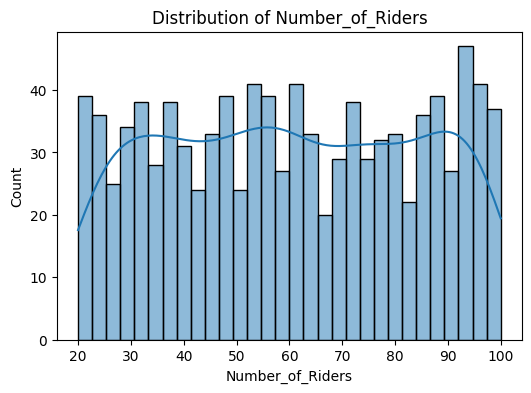

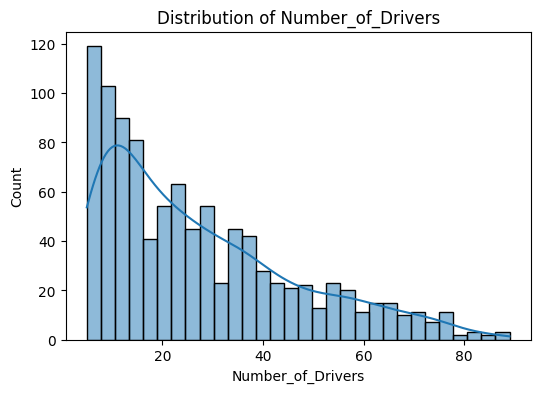

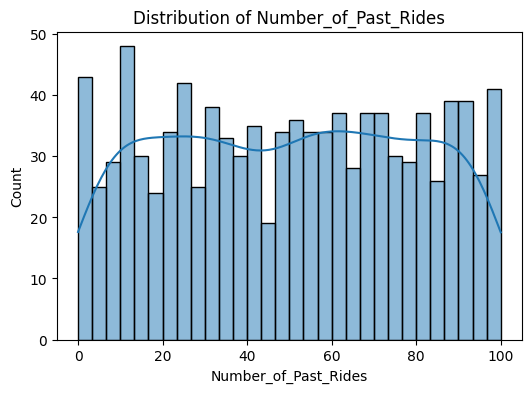

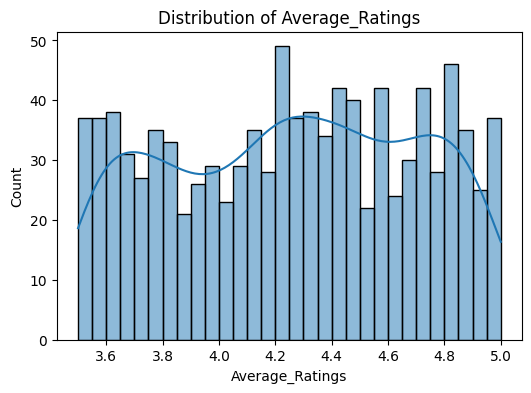

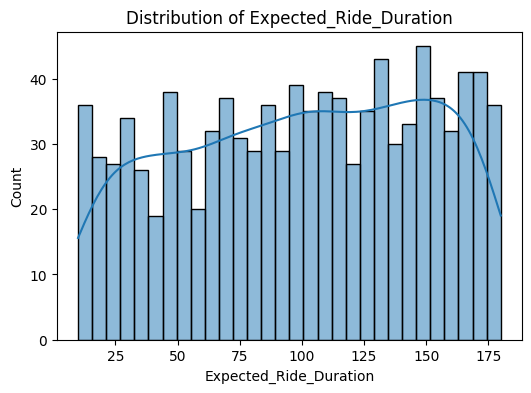

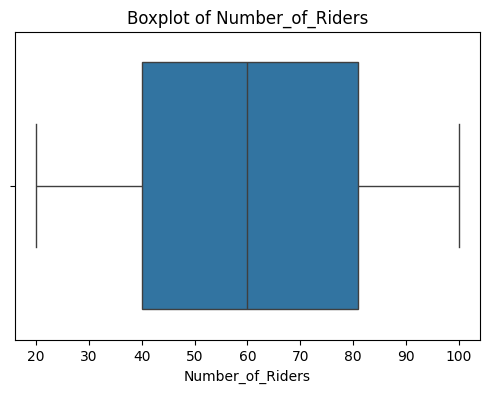

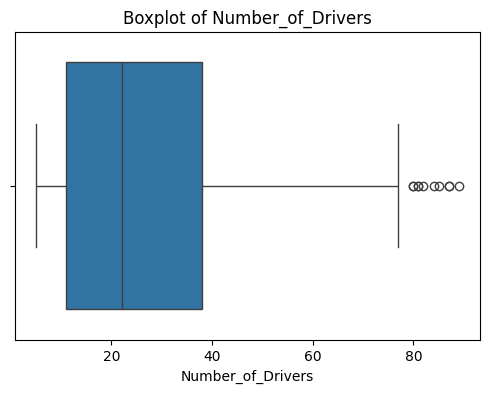

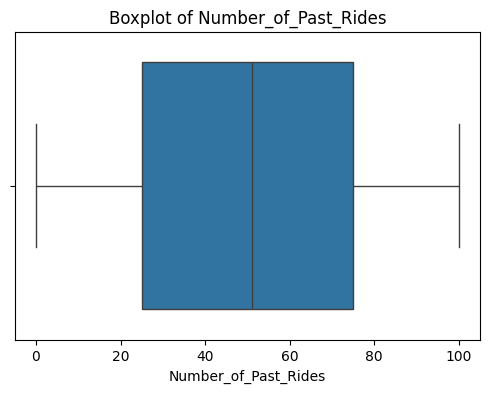

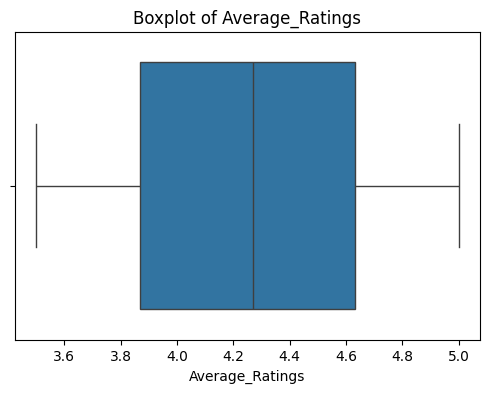

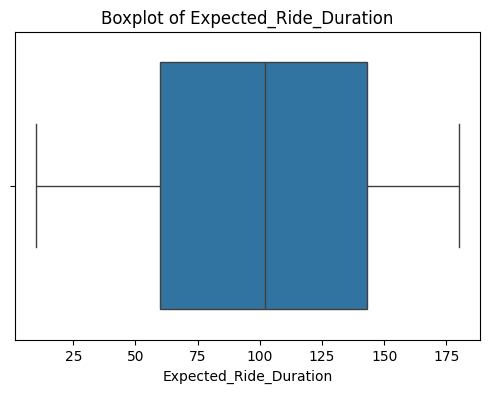

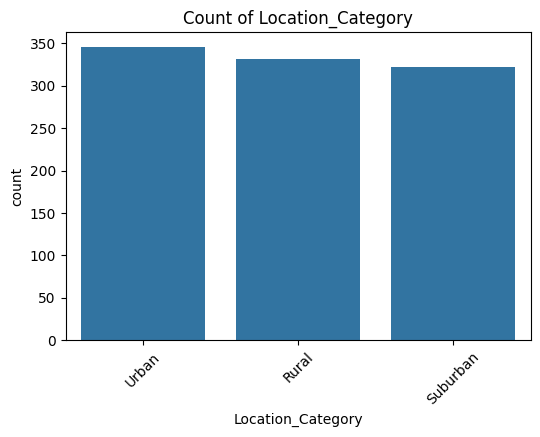

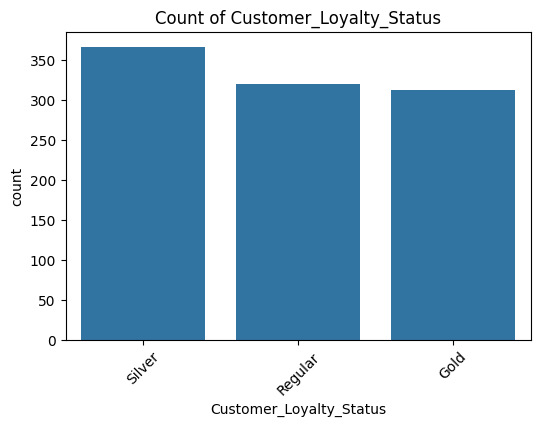

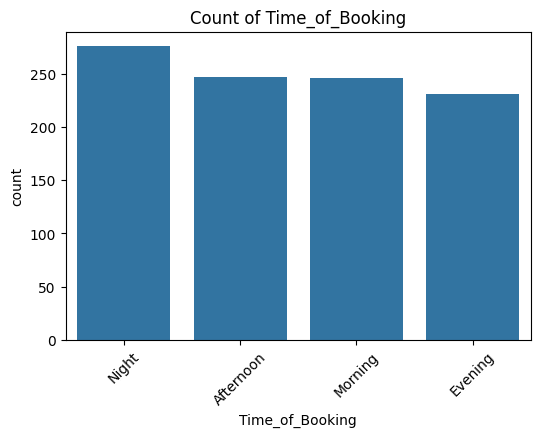

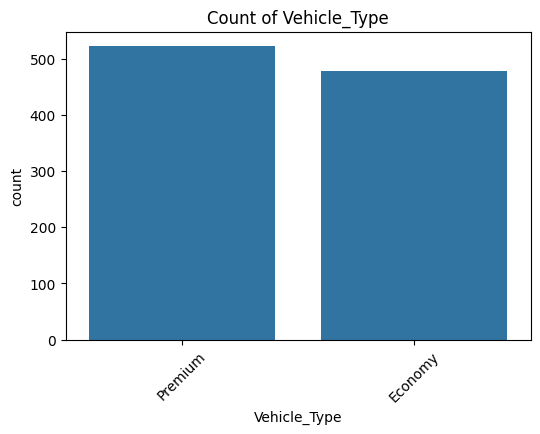

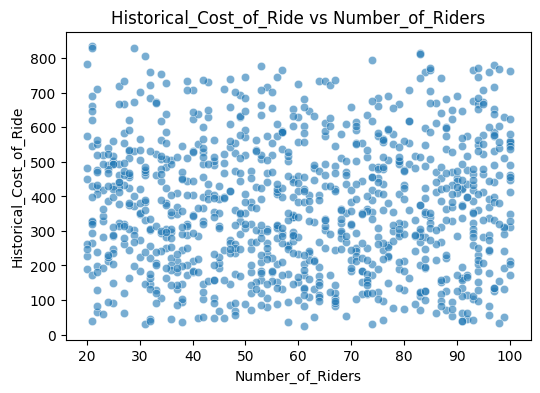

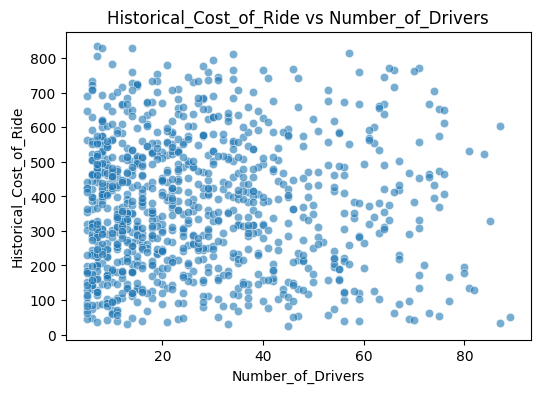

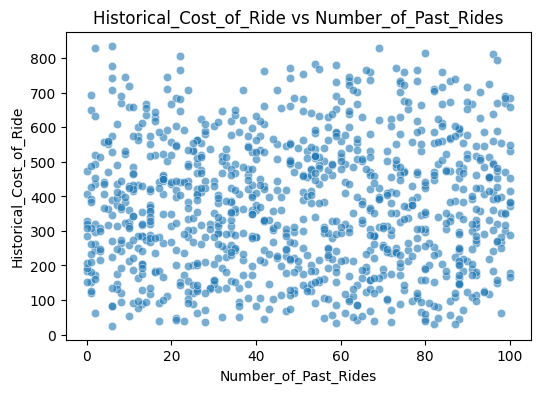

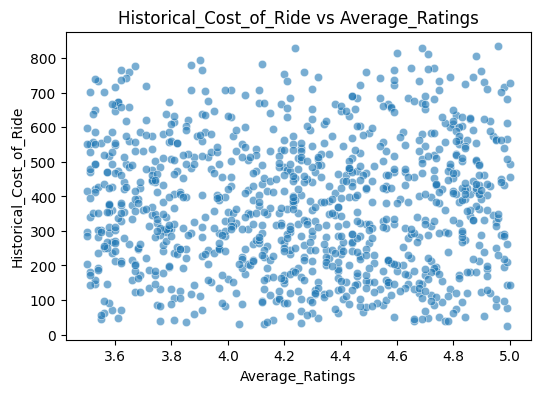

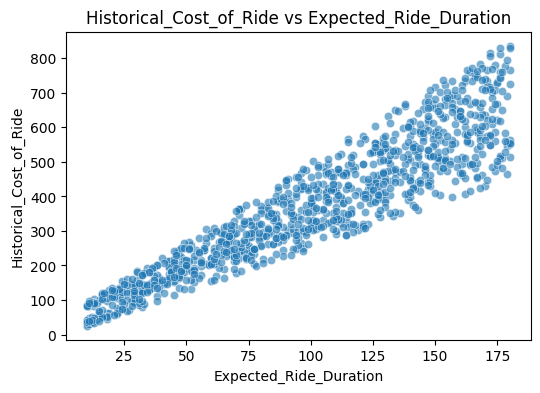

No 'p_complete' column found for conversion by segments.


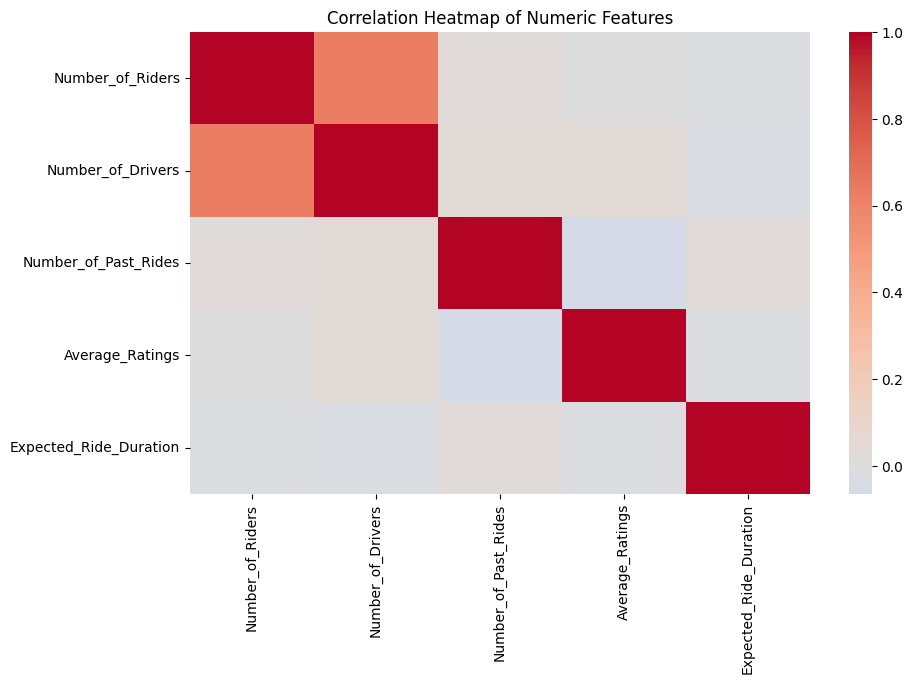

In [24]:


# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns


# Define numeric and categorical columns
num_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Optionally, remove your target column from features if it's numeric
TARGET = 'Historical_Cost_of_Ride'  # replace with your actual target column
if TARGET in num_features:
    num_features.remove(TARGET)

# 1. Numeric Distributions 
for col in num_features:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

# 2. Boxplots for Outlier Detection
for col in num_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

# 3. Categorical Counts
for col in cat_features:
    plt.figure(figsize=(6,4))
    sns.countplot(x=df[col], order=df[col].value_counts().index)
    plt.title(f"Count of {col}")
    plt.xticks(rotation=45)
    plt.show()

# 4. Relationships (Target vs Numeric Features)
for col in num_features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[col], y=df[TARGET], alpha=0.6)
    plt.title(f"{TARGET} vs {col}")
    plt.show()

# 5. Conversion by Segments (using p_complete proxy if available)
if "p_complete" in df.columns:
    plt.figure(figsize=(8,5))
    sns.barplot(x="p_complete", y=TARGET, data=df)
    plt.title("Conversion Proxy (p_complete) vs Target")
    plt.show()
else:
    print("No 'p_complete' column found for conversion by segments.")

# 6. Correlation Heatmap (numeric features + engineered features if present)
plt.figure(figsize=(10,6))
corr = df[num_features].corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()


In [25]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("C:/Users/D.Samhitha Franklin/Downloads/dynamic_pricing.csv")

# ---------------- FEATURE ENGINEERING ----------------

# Supply tightness: riders per driver
df["Supply_Tightness"] = df["Number_of_Riders"] / (df["Number_of_Drivers"] + 1e-5)

# Loyalty Score: normalized past rides (0–1 scale)
df["Loyalty_Score"] = df["Number_of_Past_Rides"] / df["Number_of_Past_Rides"].max()

# Vehicle Factor: based on average ratings
df["Vehicle_Factor"] = 1 + (df["Average_Ratings"] - df["Average_Ratings"].mean())/10

# Cost per minute
df["Cost_per_Min"] = df["Historical_Cost_of_Ride"] / df["Expected_Ride_Duration"]

# Completion probability proxy (from ratings)
df["p_complete"] = df["Average_Ratings"] / df["Average_Ratings"].max()

# Simulate Peak (if riders > 75th percentile → peak demand)
df["Peak"] = (df["Number_of_Riders"] > df["Number_of_Riders"].quantile(0.75)).astype(int)


# ---------------- BASELINE PRICING ENGINE ----------------
def baseline_pricing_engine(df):
    """
    Baseline Pricing Engine with inventory (supply-demand) + time (peak).
    """
    # Start with historical cost as base price
    df["baseline_price"] = df["Historical_Cost_of_Ride"].copy()

    # Inventory-based rule (supply-demand balance)
    df.loc[df["Supply_Tightness"] > 2.0, "baseline_price"] *= 1.10   # high demand, low supply → increase price
    df.loc[df["Supply_Tightness"] < 0.8, "baseline_price"] *= 0.95   # oversupply → discount

    # Time-based rule (Peak hours)
    df.loc[df["Peak"] == 1, "baseline_price"] *= 1.15

    # Loyalty discount
    df.loc[df["Loyalty_Score"] > 0.8, "baseline_price"] *= 0.90

    # Vehicle factor
    df["baseline_price"] *= df["Vehicle_Factor"]

    # Round for presentation
    df["baseline_price"] = df["baseline_price"].round(2)

    return df


# ---------------- REVENUE EVALUATION ----------------
def evaluate_revenue_lift(df):
    """
    Compare static vs baseline pricing revenue.
    """
    df["static_revenue"] = df["Historical_Cost_of_Ride"] * df["p_complete"]
    df["baseline_revenue"] = df["baseline_price"] * df["p_complete"]

    static_total = df["static_revenue"].sum()
    baseline_total = df["baseline_revenue"].sum()
    revenue_lift = ((baseline_total - static_total) / static_total) * 100

    return static_total, baseline_total, revenue_lift


# ---------------- RUN ENGINE ----------------
df = baseline_pricing_engine(df)
static_total, baseline_total, revenue_lift = evaluate_revenue_lift(df)

print("Static Pricing Revenue :", round(static_total, 2))
print("Baseline Pricing Revenue:", round(baseline_total, 2))
print("Revenue Lift (%):", round(revenue_lift, 2))

# Preview results
print(df[["Historical_Cost_of_Ride","baseline_price","Supply_Tightness","Peak","p_complete",
          "static_revenue","baseline_revenue"]].head())


Static Pricing Revenue : 317147.8
Baseline Pricing Revenue: 343760.03
Revenue Lift (%): 8.39
   Historical_Cost_of_Ride  baseline_price  Supply_Tightness  Peak  \
0               284.257273          333.85          2.000000     1   
1               173.874753          170.45          1.487179     0   
2               329.795469          320.98          1.354838     0   
3               470.201232          597.94          3.178570     1   
4               579.681422          606.58          3.545453     0   

   p_complete  static_revenue  baseline_revenue  
0       0.894      254.126002         298.46190  
1       0.812      141.186299         138.40540  
2       0.798      263.176784         256.14204  
3       0.862      405.313462         515.42428  
4       0.754      437.079792         457.36132  
